In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
import shap
from imblearn.over_sampling import SMOTE

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('Churn_Modelling.csv',index_col=0)

#2. data_preprocessing
# missing D(4개 행 제거)
data.isnull().sum()
nan_data = data.dropna()
print('결측 처리 :' ,nan_data.shape)

# duplicated D(2행 제거)
nan_data[nan_data.duplicated()]
new_data = nan_data[~nan_data.duplicated()]
print('중복 처리 :',new_data.shape)

#encoding : gender-label ( Female = 0, male = 1) /  geography-onehot
le = LabelEncoder()
new_data['Gender'] = le.fit_transform(new_data["Gender"])

oe = OneHotEncoder()
oe.fit(new_data[['Geography']])
geo_csr = oe.transform(new_data[['Geography']])
csr_df = pd.DataFrame(geo_csr.toarray(), columns = oe.get_feature_names_out())
df = new_data.reset_index(drop=True)  # df 인덱스 초기화
csr_df = csr_df.reset_index(drop=True)  # csr_df 인덱스 초기화
inco_df = pd.concat([df,csr_df],axis=1)

#check
int_data = inco_df.drop(columns=['CustomerId', 'Surname','Geography'])
X = int_data.drop("Exited", axis=1)
y_true = int_data['Exited']
print('전처리 완료:',X.shape,y_true.shape)
print('----------------------------')

#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true,stratify = y_true,test_size = 0.3, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#minmaxscaling - 적용유무 검토 
target_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

mn_sc = MinMaxScaler()
X_train_sc[target_features] = mn_sc.fit_transform(X_train[target_features])
X_test_sc[target_features] = mn_sc.transform(X_test[target_features]) #테스터는 정규화 학습 안함 

#Over Sampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc, y_train)
print("SMOTE 적용 후 데이터 크기:", X_train_res.shape, y_train_res.shape)
print(f'original : {y_train.value_counts()}')
print(f'smote : {y_train_res.value_counts()}')

print('----------------------------')

결측 처리 : (9998, 13)
중복 처리 : (9996, 13)
전처리 완료: (9996, 12) (9996,)
----------------------------
데이터 분리 후 크기 :  (6997, 12) (2999, 12) (6997,) (2999,)
SMOTE 적용 후 데이터 크기: (11142, 12) (11142,)
original : Exited
0    5571
1    1426
Name: count, dtype: int64
smote : Exited
0    5571
1    5571
Name: count, dtype: int64
----------------------------


In [55]:
# coef 인자에는 .coef_ 어트리뷰트가 들어가고, names에는 칼럼명이 들어감

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()



정확도 :  0.72324108036012
f1-score :  0.5117647058823529
recall :  0.7119476268412439
예측도 :  0.39944903581267216


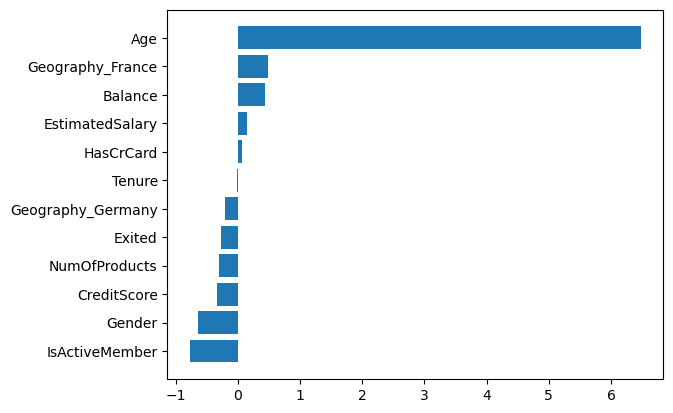

In [59]:
# SVM 모델
import sklearn.svm
clf = sklearn.svm.SVC(kernel='linear',random_state=42)

clf.fit(X_train_res, y_train_res)

y_pred_svc = clf.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc))
print("f1-score : ", f1_score(y_test, y_pred_svc))
print("recall : ", recall_score(y_test, y_pred_svc))
print("예측도 : ", precision_score(y_test, y_pred_svc))

f_importances(clf.coef_[0], list(int_data.columns))

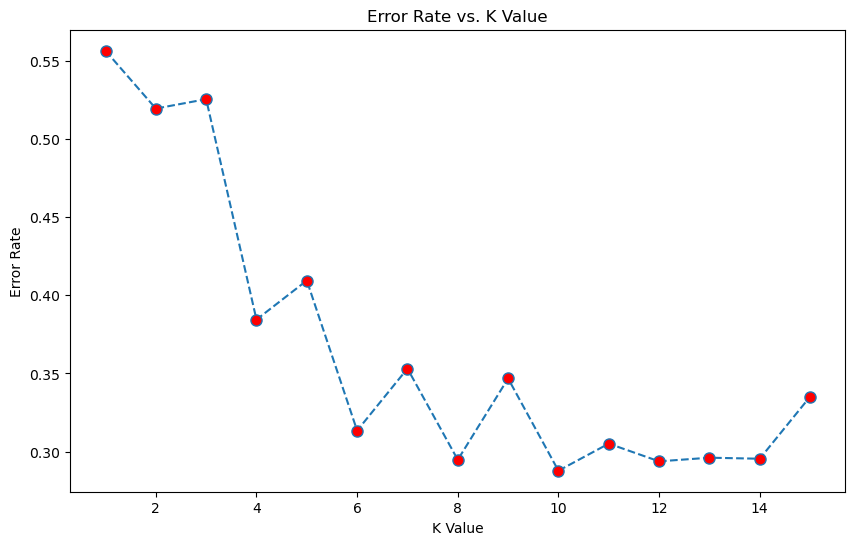

In [61]:
# KNN 모델, 추가 전처리 없을 시 K=14에서 에러율 제일 작음
error_rate = []

for i in range(1, 16):
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train_res, y_train_res)
    y_pred_i = knn_i.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), error_rate, marker='o', linestyle='dashed', markersize=8, markerfacecolor='red')
plt.title("Error Rate vs. K Value")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.show()

In [80]:
k = 4
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_knn))
print("f1-score : ", f1_score(y_test, y_pred_knn))
print("recall : ", recall_score(y_test, y_pred_knn))
print("예측도 : ", precision_score(y_test, y_pred_knn))

정확도 :  0.745248416138713
f1-score :  0.44233576642335765
recall :  0.4959083469721768
예측도 :  0.39920948616600793


In [58]:
from sklearn.inspection import permutation_importance

pfi_knn = permutation_importance(knn.best_estimator_, X_test, y_test, n_repeats=10, scoring = 'r2', random_state=42)

# 1 : feature별 Score 분포 kde
plt.figure(figsize = (12,8))
for i,vars in enumerate(list(X_test)) :
    sns.kdeplot(pfi_knn.importances[i], label = vars)

plt.legend()
plt.show()

# 2 : feature별 Score 분포 box
sorted_idx = pfi_knn.importances_mean.argsort()
plt.figure(figsize = (12,8))
plt.boxplot(pfi_knn.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'best_estimator_'

In [43]:
# 각 모델 정확도를 제외한 모든 수치가 낮아 실사용 불가, optuna를 이용한 튜닝 수행
import optuna
import itertools
import sklearn.svm
import sklearn.model_selection
from sklearn.metrics import classification_report

In [75]:
# SVC optuna 수행
def objective(trial):

    svc_c = trial.suggest_float("C", 0.001, 1000, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_train_res, y_train_res, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-31 19:56:02,993] A new study created in memory with name: no-name-25931663-3140-45fc-b188-8dab9a111484
[I 2025-01-31 19:56:05,619] Trial 0 finished with value: 0.8201400107700593 and parameters: {'C': 222.25874799096732}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:08,143] Trial 1 finished with value: 0.7249147370310537 and parameters: {'C': 0.10576081869212717}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:10,815] Trial 2 finished with value: 0.6739364566505116 and parameters: {'C': 0.031080419634489737}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:13,085] Trial 3 finished with value: 0.7337102854065698 and parameters: {'C': 0.16885870202250378}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:18,028] Trial 4 finished with value: 0.8278585532220427 and parameters: {'C': 775.866972942395}. Best is trial 4 with value: 0.8278585532220427.
[I 2025-01-31 19:56:19,786] Trial 5 finished with

Number of finished trials: 100
Best trial:
  Value: 0.8285765571710645
  Params: 
    C: 991.9788157685106


In [79]:
# 최적화된 하이퍼파라미터로 튜닝

svc_c = study.best_params['C']
model = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)
model.fit(X_train_res, y_train_res)

y_pred_svc_op = model.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc_op))
print("f1-score : ", f1_score(y_test, y_pred_svc_op, average='macro'))
print("recall : ", recall_score(y_test, y_pred_svc_op))
print("예측도 : ", precision_score(y_test, y_pred_svc_op))

정확도 :  0.7812604201400467
f1-score :  0.6991144162463876
recall :  0.6350245499181669
예측도 :  0.4725943970767357


In [70]:
# KNN 최적화, 목적함수 정의
from sklearn.model_selection import cross_val_score

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: obj_knn(trial, X_train_res, y_train_res), n_trials = 100)

# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

[I 2025-01-31 19:52:15,687] A new study created in memory with name: no-name-327a000e-2fdd-40ee-ab6b-d672004b3daa
[I 2025-01-31 19:52:15,887] Trial 0 finished with value: 0.787216991913261 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.787216991913261.
[I 2025-01-31 19:52:15,992] Trial 1 finished with value: 0.8713623911643342 and parameters: {'n_neighbors': 2, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,105] Trial 2 finished with value: 0.8132242792074651 and parameters: {'n_neighbors': 25, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,209] Trial 3 finished with value: 0.8372735375874905 and parameters: {'n_neighbors': 13, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,349] Trial 4 finished with value: 0.778

Best trial:
  Value: 0.8735201058347499
  Params: 
    n_neighbors: 1
    metric: manhattan
    weights: distance


In [ ]:
# bset parmeter training
knn_model.fit(X_train_res,y_train_res)
y_pred_knn_op = knn_model.predict(X_test)

print("정확도 : ", accuracy_score(y_test, y_pred_knn_op))
print("f1-score : ", f1_score(y_test, y_pred_knn_op))
print("recall : ", recall_score(y_test, y_pred_knn_op))
print("예측도 : ", precision_score(y_test, y_pred_knn_op))

정확도 :  0.6948982994331444
f1-score :  0.3728581220013708
recall :  0.4451718494271686
예측도 :  0.32075471698113206


In [51]:
# 모델과 하이퍼파라미터 범위 정의
param_grids = {    
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'SVM': {
        'model': svm.SVC(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmod'],
            'gamma': ['auto', 'scale']
        }
    },             
}

# 결과를 저장
results = {}

In [52]:
# 각 모델별 학습 및 평가
from sklearn.model_selection import cross_val_score, GridSearchCV
for name, model_info in param_grids.items():
    print(f"\n{name} 모델 학습 중...")

    # GridSearchCV를 통한 하이퍼파라미터 튜닝
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # 모델 학습
    grid_search.fit(X_train_res, y_train_res)

    # 5-fold cv
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train_res, y_train_res, cv=5)

    # prediction
    y_pred = grid_search.predict(X_test_sc)

    # 평가 지표 계산
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_scores_mean': cv_scores.mean(),
        'cv_scores_std': cv_scores.std(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'avg_precision': average_precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }




KNN 모델 학습 중...

SVM 모델 학습 중...

=== KNN 모델 결과 ===
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best CV Score: 0.8686
5-fold CV Score: 0.8686 (+/- 0.0105)
Test Accuracy: 0.7446
F1 Score: 0.4284
Recall: 0.4697
Precision: 0.3937
Average Precision: 0.2930

Confusion Matrix:
[[1946  442]
 [ 324  287]]

=== SVM 모델 결과 ===
Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.8335
5-fold CV Score: 0.8335 (+/- 0.0505)
Test Accuracy: 0.7816
F1 Score: 0.5423
Recall: 0.6350
Precision: 0.4732
Average Precision: 0.3748

Confusion Matrix:
[[1956  432]
 [ 223  388]]


In [78]:
# 결과 출력
for name, result in results.items():
    print(f"\n=== {name} 모델 결과 ===")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best CV Score: {result['best_score']:.4f}")
    print(f"5-fold CV Score: {result['cv_scores_mean']:.4f} (+/- {result['cv_scores_std'] * 2:.4f})")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Average Precision: {result['avg_precision']:.4f}")
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])


=== KNN 모델 결과 ===
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best CV Score: 0.8686
5-fold CV Score: 0.8686 (+/- 0.0105)
Test Accuracy: 0.7446
F1 Score: 0.4284
Recall: 0.4697
Precision: 0.3937
Average Precision: 0.2930

Confusion Matrix:
[[1946  442]
 [ 324  287]]

=== SVM 모델 결과 ===
Best Parameters: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.8335
5-fold CV Score: 0.8335 (+/- 0.0505)
Test Accuracy: 0.7816
F1 Score: 0.5423
Recall: 0.6350
Precision: 0.4732
Average Precision: 0.3748

Confusion Matrix:
[[1956  432]
 [ 223  388]]
